Data loader

In [118]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        # Modify the mask_path to match the naming convention of the masks
        mask_name = "seg_" + img_name
        mask_path = os.path.join(self.mask_dir, mask_name)
        image = Image.open(img_path)
        mask = Image.open(mask_path).convert("L")  # Masks are grayscale
        if self.transform:
            # print("transform")
            image = self.transform(image)
            mask = self.transform(mask)
        return image, mask



Double Conv Net

In [119]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class ConvNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(ConvNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.MaxPool2d(2)
        self.conv1 = DoubleConv(64, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv2 = DoubleConv(128, 64)
        self.outc = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x2 = self.conv1(x2)
        x3 = self.up1(x2)
        x4 = torch.cat([x3, x1], dim=1)
        x4 = self.conv2(x4)
        logits = self.outc(x4)
        return logits


Attention + Double Conv Net

In [120]:
import torch
import torch.nn as nn
import torch
import torch.nn as nn

class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

# Include this AttentionBlock in your UNet architecture where necessary.

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(.1),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class ConvNet_Attention(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(ConvNet_Attention, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.MaxPool2d(2)
        self.conv1 = DoubleConv(64, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.attention1 = AttentionBlock(F_g=64, F_l=64, F_int=32)
        self.conv2 = DoubleConv(128, 64)
        self.outc = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x2 = self.conv1(x2)
        x3 = self.up1(x2)
        x1_att = self.attention1(x3, x1) 
        x4 = torch.cat([x3, x1_att], dim=1)
        x4 = self.conv2(x4)
        logits = self.outc(x4)
        return logits

Standard Unet

In [121]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        # Encoder (Downsampling Path)
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = DoubleConv(64, 128)
        self.down2 = DoubleConv(128, 256)
        self.down3 = DoubleConv(256, 512)
        self.down4 = DoubleConv(512, 1024)

        # Pooling
        self.pool = nn.MaxPool2d(2)

        # Decoder (Upsampling Path)
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.att1 = AttentionBlock(F_g=512, F_l=512, F_int=256)
        self.upconv1 = DoubleConv(1024, 512)

        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.att2 = AttentionBlock(F_g=256, F_l=256, F_int=128)
        self.upconv2 = DoubleConv(512, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.att3 = AttentionBlock(F_g=128, F_l=128, F_int=64)
        self.upconv3 = DoubleConv(256, 128)

        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.att4 = AttentionBlock(F_g=64, F_l=64, F_int=32)
        self.upconv4 = DoubleConv(128, 64)

        # Output Convolution
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.inc(x)
        x2 = self.pool(x1)
        x2 = self.down1(x2)
        x3 = self.pool(x2)
        x3 = self.down2(x3)
        x4 = self.pool(x3)
        x4 = self.down3(x4)
        x5 = self.pool(x4)
        x5 = self.down4(x5)

        # Decoder
        x = self.up1(x5)
        x1_att = self.att1(g=x, x=x4)
        x = torch.cat([x1_att, x], dim=1)
        x = self.upconv1(x)

        x = self.up2(x)
        x2_att = self.att2(g=x, x=x3)
        x = torch.cat([x2_att, x], dim=1)
        x = self.upconv2(x)

        x = self.up3(x)
        x3_att = self.att3(g=x, x=x2)
        x = torch.cat([x3_att, x], dim=1)
        x = self.upconv3(x)

        x = self.up4(x)
        x4_att = self.att4(g=x, x=x1)
        x = torch.cat([x4_att, x], dim=1)
        x = self.upconv4(x)

        # Output
        logits = self.outc(x)
        return logits


Attention Unet

In [122]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet_Attention(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet_Attention, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.MaxPool2d(2)
        self.conv1 = DoubleConv(64, 128)
        self.down2 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(128, 256)
        self.down3 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(256, 512)
        self.down4 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(512, 1024)

        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.upconv1 = DoubleConv(1024, 512)
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.upconv2 = DoubleConv(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.upconv3 = DoubleConv(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.upconv4 = DoubleConv(128, 64)

        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x2 = self.conv1(x2)
        x3 = self.down2(x2)
        x3 = self.conv2(x3)
        x4 = self.down3(x3)
        x4 = self.conv3(x4)
        x5 = self.down4(x4)
        x5 = self.conv4(x5)

        x = self.up1(x5)
        x = torch.cat([x, x4], dim=1)
        x = self.upconv1(x)

        x = self.up2(x)
        x = torch.cat([x, x3], dim=1)
        x = self.upconv2(x)

        x = self.up3(x)
        x = torch.cat([x, x2], dim=1)
        x = self.upconv3(x)

        x = self.up4(x)
        x = torch.cat([x, x1], dim=1)
        x = self.upconv4(x)

        logits = self.outc(x)
        return logits


Training

In [126]:
import torch.optim as optim
from torchvision import transforms
import numpy as np
from torch.utils.data import random_split
from torchvision.transforms import RandomHorizontalFlip, RandomRotation

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transformations, dataset, and dataloader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128))
])
dataset = SegmentationDataset('BU-BIL/BU-BIL_Dataset1/RawImages', 'BU-BIL/BU-BIL_Dataset1/GoldStandard', transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Define the proportion or absolute numbers for train and validation sets
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation

# Splitting the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders for training and validation datasets
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

dataloaders = {
    'train': train_loader,
    'val': val_loader
}


# Initialize the model, loss function, and optimizer
model = UNet_Attention(n_channels=1, n_classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

import torch

def iou(outputs, labels):
    # Assuming outputs and labels are torch tensors that have been binarized
    # i.e., in the format of 1 for foreground and 0 for background
    intersection = (outputs & labels).float().sum((1, 2))  # Intersection points
    union = (outputs | labels).float().sum((1, 2))         # Union points

    # Compute the IoU and avoid division by 0; return array of shape: batch_size
    iou = intersection / union.clamp(min=1e-6)
    return iou.mean().item()  # Return the average IoU over the batch

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        print(f"Starting Epoch {epoch+1}/{num_epochs}...")
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_iou = 0.0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # Assume outputs are probabilities and use threshold to binarize
                    preds = outputs < 0.5  # Adjust threshold as needed
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_iou += iou(preds, labels == 0)  # Assuming labels are also probabilities

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_iou = running_iou / len(dataloaders[phase])
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f}")
            print(f"{phase.capitalize()} IoU: {epoch_iou:.4f}")

# Example use
train_model(model, dataloaders, criterion, optimizer, num_epochs=150)



Starting Epoch 1/150...
Train Loss: 0.5985
Train IoU: 0.0491
Val Loss: 0.8986
Val IoU: 0.0253
Starting Epoch 2/150...
Train Loss: 0.3835
Train IoU: 0.0463
Val Loss: 0.4829
Val IoU: 0.0261
Starting Epoch 3/150...
Train Loss: 0.3022
Train IoU: 0.0459
Val Loss: 0.2884
Val IoU: 0.0123
Starting Epoch 4/150...
Train Loss: 0.2530
Train IoU: 0.0402
Val Loss: 0.2557
Val IoU: 0.0186
Starting Epoch 5/150...
Train Loss: 0.2210
Train IoU: 0.0395
Val Loss: 0.2322
Val IoU: 0.0541
Starting Epoch 6/150...
Train Loss: 0.1942
Train IoU: 0.0735
Val Loss: 0.1758
Val IoU: 0.1001
Starting Epoch 7/150...
Train Loss: 0.1808
Train IoU: 0.1018
Val Loss: 0.2424
Val IoU: 0.0972
Starting Epoch 8/150...
Train Loss: 0.1648
Train IoU: 0.0878
Val Loss: 0.2152
Val IoU: 0.1295
Starting Epoch 9/150...
Train Loss: 0.1510
Train IoU: 0.1188
Val Loss: 0.1616
Val IoU: 0.1413
Starting Epoch 10/150...
Train Loss: 0.1436
Train IoU: 0.1109
Val Loss: 0.2267
Val IoU: 0.1270
Starting Epoch 11/150...
Train Loss: 0.1257
Train IoU: 0.13

Single image evaluation

[[6.8361216 7.3700953 7.591457  ... 8.713008  8.786614  8.156009 ]
 [7.402586  7.348928  7.3894196 ... 8.618527  8.766215  7.6066327]
 [6.3364434 6.14686   6.064595  ... 8.172023  7.895698  8.423997 ]
 ...
 [7.5754113 6.0576925 7.0328674 ... 8.71275   7.661135  7.998423 ]
 [7.7453065 7.813095  8.174598  ... 7.662537  6.4855084 8.230364 ]
 [7.785476  8.7043085 9.305663  ... 8.270619  7.500755  9.177879 ]]


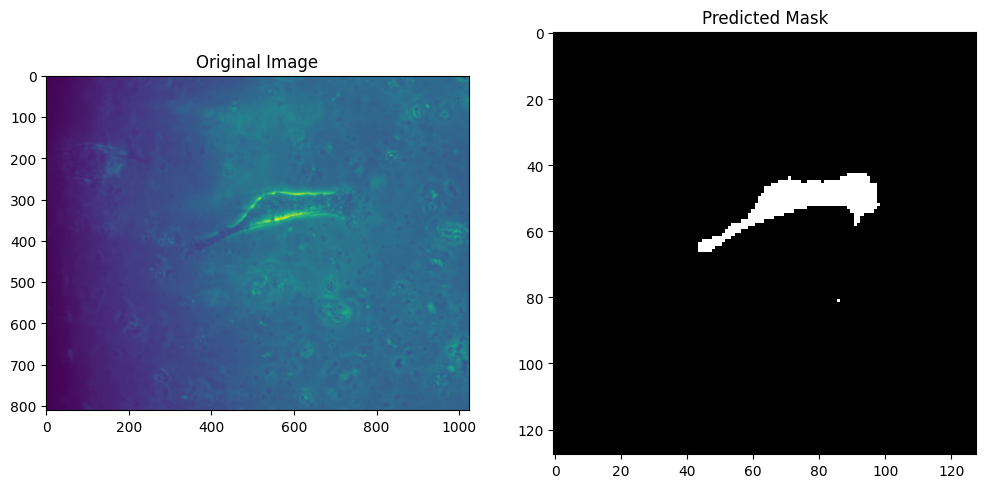

In [128]:
fname = 'B01'
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

# Ensure the predictions directory exists
os.makedirs("predictions", exist_ok=True)

# Load and preprocess the image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128,128)),
])

# image_path = image_path = 'BU-BIL/BU-BIL_Dataset1/RawImages/B35.png' 
image_path = f'BU-BIL/BU-BIL_Dataset1/RawImages/{fname}.png'
image = Image.open(image_path)
image = transform(image).unsqueeze(0)  # Add batch dimension

# Predict the mask with the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    prediction = model(image.to(device))

# Post-process the prediction
predicted_mask = prediction.squeeze().cpu().numpy()
print(predicted_mask)
predicted_mask = predicted_mask < .5  # Threshold the predictions


# Finding connected components in the predicted mask
num_labels, labels_im = cv2.connectedComponents(predicted_mask.astype(np.uint8))

# Identify the largest component (excluding the background)
biggest_size = 0
biggest_label = 1
sec_biggest_size = 0
sec_biggest_label = 1
for label in range(1, num_labels):  # Start from 1 to ignore the background (label 0)
    mask = labels_im == label
    component_size = np.sum(mask)
    if component_size > biggest_size:
        sec_biggest_size = biggest_size
        sec_biggest_label = biggest_label
        biggest_size = component_size
        biggest_label = label
    elif component_size > sec_biggest_size:
        sec_biggest_size = component_size
        sec_biggest_label = label

# Create a mask for the largest component
largest_component_mask = ((labels_im == biggest_label) | (labels_im == sec_biggest_label)).astype(np.uint8)

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(Image.open(image_path))
ax1.set_title('Original Image')
ax2.imshow(largest_component_mask, cmap='gray')
ax2.set_title('Predicted Mask')

# Save the prediction
predicted_mask_image = Image.fromarray((predicted_mask * 255).astype(np.uint8))
predicted_mask_image.save(f"predictions/seg_B01.png")

plt.show()

In [129]:
from PIL import Image
import numpy as np

def calculate_iou(pred_array, gold_array):
    # Ensure both arrays are boolean (True for object, False for background)
    intersection = np.logical_and(pred_array, gold_array)
    union = np.logical_or(pred_array, gold_array)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

# Load gold standard image and convert to binary
gold_standard_path = f'BU-BIL/BU-BIL_Dataset1/GoldStandard/seg_{fname}.png' # Update this path
gold_image = Image.open(gold_standard_path).convert('L')

# Resize the gold standard image to match predicted image size
predicted_shape = (128, 128)  # Example shape, update this to your predicted image's dimensions
gold_image = gold_image.resize(predicted_shape, Image.Resampling.LANCZOS)

# Convert gold standard image to binary array
gold_array = np.array(gold_image)
gold_binary = (gold_array < 128).astype(int)  # Assuming threshold at mid-point 128

# Load your predicted image (already a 2D array of True/False)
# Assuming `predicted_image` is loaded somewhere else in your environment
# Example: predicted_image = np.random.choice([True, False], size=(128, 128))

# Convert predicted image from True/False to 1/0
predicted_binary = largest_component_mask.astype(int)

# Calculate IoU
iou_score = calculate_iou(predicted_binary, gold_binary)
print("The IoU score is:", iou_score)



predicted_image = (predicted_binary * 255).astype(np.uint8)  # Convert to 0-255 scale
gold_image = (gold_binary * 255).astype(np.uint8)           # Convert to 0-255 scale

# Convert numpy arrays to PIL images
predicted_pil_image = Image.fromarray(predicted_image, mode='L')  # 'L' for (8-bit pixels, black and white)
gold_pil_image = Image.fromarray(gold_image, mode='L')

# # Display the images
predicted_pil_image.show()
gold_pil_image.show()


The IoU score is: 0.9325581395348838


Model Evaluation

In [130]:

import cv2

# Directory of images
#################################################################
#################################################################
#################################################################
# image_dir = 'final_p/RawImages'
# gold_standard_dir = 'final_p/GoldStandard'
# output_dir = 'final_p/dataset1_results'

image_dir = 'BU-BIL/BU-BIL_Dataset1/RawImages'
gold_standard_dir = 'BU-BIL/BU-BIL_Dataset1/GoldStandard'
output_dir = 'BU-BIL/BU-BIL_Dataset1/Results_AttentionUNet'
#################################################################
#################################################################
#################################################################


# Get list of files
image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]

pixel_accuracies = []
ious = []

for filename in image_files:
    original_image = os.path.join(image_dir, filename)
    gold_standard_image = os.path.join(gold_standard_dir, 'seg_' + filename)

    image = Image.open(original_image)
    image = transform(image).unsqueeze(0)  # Add batch dimension

    # Predict the mask with the model
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        prediction = model(image.to(device))

    # Post-process the prediction
    predicted_mask = prediction.squeeze().cpu().numpy()
    # print(predicted_mask)
    predicted_mask = predicted_mask < .5  # Threshold the predictions


    # Finding connected components in the predicted mask
    num_labels, labels_im = cv2.connectedComponents(predicted_mask.astype(np.uint8))

    # Identify the largest component (excluding the background)
    biggest_size = 0
    biggest_label = 1
    # sec_biggest_size = 0
    # sec_biggest_label = 1
    for label in range(1, num_labels):  # Start from 1 to ignore the background (label 0)
        mask = labels_im == label
        component_size = np.sum(mask)
        if component_size > biggest_size:
            # sec_biggest_size = biggest_size
            # sec_biggest_label = biggest_label
            biggest_size = component_size
            biggest_label = label
        # elif component_size > sec_biggest_size:
            # sec_biggest_size = component_size
            # sec_biggest_label = label

    # Create a mask for the largest component
    largest_component_mask = ((labels_im == biggest_label) | (labels_im == sec_biggest_label)).astype(np.uint8)

    gold_image = Image.open(gold_standard_image).convert('L')

    # Resize the gold standard image to match predicted image size
    predicted_shape = (128, 128)  # Example shape, update this to your predicted image's dimensions
    gold_image = gold_image.resize(predicted_shape, Image.Resampling.LANCZOS)

    # Convert gold standard image to binary array
    gold_array = np.array(gold_image)
    gold_binary = (gold_array < 128).astype(int)  # Assuming threshold at mid-point 128

    # Load your predicted image (already a 2D array of True/False)
    # Assuming `predicted_image` is loaded somewhere else in your environment
    # Example: predicted_image = np.random.choice([True, False], size=(128, 128))

    # Convert predicted image from True/False to 1/0
    predicted_binary = largest_component_mask.astype(int)

    # Calculate IoU
    iou_score = calculate_iou(predicted_binary, gold_binary)
    print("The IoU score is:", iou_score, filename)
    ious += [iou_score]
    predicted_image = (predicted_binary * 255).astype(np.uint8)  # Convert to 0-255 scale

    # Convert numpy arrays to PIL images
    predicted_pil_image = Image.fromarray(predicted_image, mode='L')  # 'L' for (8-bit pixels, black and white)

    # # Display the images
    # predicted_pil_image.save(f'{output_dir}/seg_{filename}')
print(np.mean(ious))


The IoU score is: 0.9325581395348838 B01.png
The IoU score is: 0.7427884615384616 B02.png
The IoU score is: 0.9457831325301205 B03.png
The IoU score is: 0.7624584717607974 B04.png
The IoU score is: 0.7061068702290076 B05.png
The IoU score is: 0.9048951048951049 B06.png
The IoU score is: 0.7285012285012284 B07.png
The IoU score is: 0.7226086956521739 B08.png
The IoU score is: 0.8780841799709724 B09.png
The IoU score is: 0.905982905982906 B10.png
The IoU score is: 0.8884422110552764 B11.png
The IoU score is: 0.7966244725738396 B12.png
The IoU score is: 0.4557867360208062 B13.png
The IoU score is: 0.8650519031141869 B14.png
The IoU score is: 0.8911290322580645 B15.png
The IoU score is: 0.9219143576826196 B16.png
The IoU score is: 0.9578947368421052 B17.png
The IoU score is: 0.8526315789473684 B18.png
The IoU score is: 0.928345626975764 B19.png
The IoU score is: 0.9274193548387096 B20.png
The IoU score is: 0.6871657754010695 B21.png
The IoU score is: 0.9151515151515152 B22.png
The IoU scor